In [1]:
## PATH settings
import os
import sys
project_root = os.path.abspath(os.path.join(os.getcwd(), '../../'))
sys.path.append(project_root)
COMMON_PATH = os.path.join(project_root, 'common')

In [2]:
## Bespoke class imports
from common.database.adatabase import ADatabase
from common.processor.processor import Processor as p
from financial_common.risk.rolling_factor_analysis import RollingFactorAnalysis
from financial_common.risk.single_index_capm import SingleIndexCAPM
from financial_common.indicator.indicator import Indicator
from financial_common.risk.benchmark import Benchmark
from financial_common.portfolio_management.metrics import Metrics
from financial_common.portfolio_management.portfolio_selection import PortfolioSelection
from financial_common.risk.risk_type import RiskType
import numpy as np

In [3]:
## Import standard packages
from xgboost import XGBRegressor
from datetime import timedelta
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from time import sleep

In [4]:
sec = ADatabase("sec")
market = ADatabase("market")
fred = ADatabase("fred")

In [5]:
## Retrieve existing stocks 
market.connect()
index = market.retrieve("ticker_overview")
market.disconnect()
sic_codes = pd.read_csv("../../csv_files/sic_codes.csv").rename(columns={"SIC Code":"sic_code","Office":"office"}).dropna()
index["sic_code"] = index["sic_code"].fillna(0).astype(int)
sic_codes["sic_code"] = sic_codes["sic_code"].fillna(0).astype(int)
index = index.merge(sic_codes[["sic_code","office"]],on="sic_code")

## Retrieve previously calculated Macro Projections
fred.connect()
sp500 = p.lower_column(fred.retrieve("sp500_projections").rename(columns={"prediction":"sp500_prediction"}))
sp500 = p.utc_date(sp500)
interest_rates = p.lower_column(fred.retrieve("market_yield").rename(columns={"value":"rf"}))
interest_rates = p.utc_date(interest_rates)
interest_rates["rf"] = interest_rates["rf"].replace(".",0)
interest_rates["rf"] = [float(x) / 100 for x in interest_rates["rf"]]
fred.disconnect()
macro = sp500.merge(interest_rates,on="date",how="left")
macro = p.utc_date(macro)

In [6]:
factors = ["assets","liabilities","revenue","reference_price"]

In [7]:
market.connect()
sec.connect()
factors_df = []
for row in tqdm(index.iterrows()):
    try:
        ticker = row[1]["ticker"]
        cik = int(row[1]["cik"])
        price = market.query("prices",{"ticker":ticker})
        filings = sec.query("filings",{"cik":cik})
        if price.index.size > 0 and filings.index.size > 0:
            price = p.utc_date(price)
            price = p.additional_date_columns(price)
            price.sort_values("date",inplace=True)
            price = Indicator.ROLLING_DOLLAR_VOLUME.calculate(price)
            filings = p.utc_date(filings)
            filings = p.lower_column(filings)
            filings = p.additional_date_columns(filings)
            ticker_factors = filings.drop(["date","month","week","cik"],axis=1).groupby(["year","quarter"]).mean().reset_index()
            price = price.drop(["date","ticker"],axis=1).groupby(["year","quarter"]).mean().reset_index()
            ticker_factors = ticker_factors.merge(price,on=["year","quarter"],how="left")
            ticker_factors = ticker_factors.ffill()
            ticker_factors["year"] = ticker_factors["year"] + 1
            if ticker_factors.index.size > 0:
                ticker_factors["ticker"] = ticker
                ticker_factors["reference_price"] = ticker_factors["adjclose"].shift(1)
                ticker_factors["y"] = ticker_factors["adjclose"].shift(-1)
                factors_df.append(ticker_factors[["year","quarter","ticker","adjclose","rolling_dollar_volume","y"]+factors])
    except Exception as e:
        print(ticker,str(e))
        continue
sec.disconnect()
market.disconnect()
factors_df = pd.concat(factors_df).sort_values(["year","quarter"])

4327it [04:45, 15.15it/s]


In [8]:
model_start = 2015
model_end = 2022
backtest_end = 2026
model = XGBRegressor(booster="gbtree",random_state=42)
factors_df = factors_df.dropna(subset=factors)
training_data = factors_df[(factors_df["year"]>=model_start) & (factors_df["year"]<model_end)].dropna()
sim = factors_df[(factors_df["year"]>=model_end-1) & (factors_df["year"]<backtest_end)].dropna(subset=factors)
model.fit(training_data[factors],training_data["y"])
sim["prediction"] = model.predict(sim[factors])
sim = sim[["ticker","year","quarter","prediction"]]

In [9]:
market.connect()
prices = []
for ticker in tqdm(index["ticker"]):
    try:
        price = p.utc_date(market.query("prices",{"ticker":ticker}))
        price = p.additional_date_columns(market.query("prices",{"ticker":ticker}))
        price.sort_values("date",inplace=True)
        price = price.merge(sim,on=["year","quarter","ticker"],how="left")
        price = p.utc_date(price)
        price = price.merge(macro,on="date",how="left")
        price["factor"] = price["prediction"] / price["adjclose"] - 1
        price = SingleIndexCAPM.apply(price)
        for member in RiskType:
            price = member.apply(price)
        prices.append(price)
    except Exception as e:
        print(str(e))
        continue
market.disconnect()

  0%|▌                                                                                                                                                        | 15/4327 [00:01<07:34,  9.50it/s]

'date'


  1%|█▏                                                                                                                                                       | 34/4327 [00:03<06:53, 10.39it/s]

'date'


  3%|████▏                                                                                                                                                   | 119/4327 [00:13<06:21, 11.03it/s]

'date'


 12%|█████████████████▉                                                                                                                                      | 512/4327 [01:00<05:24, 11.74it/s]

'date'
'date'


 12%|██████████████████▌                                                                                                                                     | 529/4327 [01:02<07:11,  8.79it/s]

'date'


 13%|███████████████████▏                                                                                                                                    | 547/4327 [01:04<05:53, 10.68it/s]

'date'


 15%|██████████████████████                                                                                                                                  | 629/4327 [01:14<06:10,  9.98it/s]

'date'
'date'


 18%|███████████████████████████▎                                                                                                                            | 777/4327 [01:32<06:07,  9.65it/s]

'date'


 19%|█████████████████████████████▌                                                                                                                          | 842/4327 [01:41<07:35,  7.65it/s]

'date'


 20%|██████████████████████████████▍                                                                                                                         | 865/4327 [01:44<07:05,  8.14it/s]

'date'


 22%|████████████████████████████████▊                                                                                                                       | 935/4327 [01:53<05:45,  9.83it/s]

'date'


 23%|██████████████████████████████████▌                                                                                                                     | 985/4327 [02:00<06:27,  8.63it/s]

'date'
'date'


 25%|█████████████████████████████████████▉                                                                                                                 | 1088/4327 [02:15<06:21,  8.50it/s]

'date'


 38%|█████████████████████████████████████████████████████████▍                                                                                             | 1647/4327 [03:28<03:42, 12.06it/s]

'date'


 41%|█████████████████████████████████████████████████████████████▎                                                                                         | 1757/4327 [03:42<05:11,  8.26it/s]

'date'


 42%|███████████████████████████████████████████████████████████████                                                                                        | 1806/4327 [03:48<04:26,  9.45it/s]

'date'


 44%|██████████████████████████████████████████████████████████████████▌                                                                                    | 1909/4327 [04:02<04:22,  9.22it/s]

'date'


 52%|███████████████████████████████████████████████████████████████████████████████                                                                        | 2265/4327 [04:50<03:14, 10.63it/s]

'date'


 53%|███████████████████████████████████████████████████████████████████████████████▌                                                                       | 2279/4327 [04:52<02:50, 12.01it/s]

'date'
'date'


 58%|███████████████████████████████████████████████████████████████████████████████████████▍                                                               | 2506/4327 [05:22<05:45,  5.27it/s]

'date'


 59%|█████████████████████████████████████████████████████████████████████████████████████████                                                              | 2552/4327 [05:28<02:49, 10.50it/s]

'date'
'date'


 62%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 2683/4327 [05:46<02:51,  9.60it/s]

'date'


 64%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 2759/4327 [05:55<02:21, 11.08it/s]

'date'


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 3030/4327 [06:31<02:18,  9.34it/s]

'date'


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 3561/4327 [07:28<00:48, 15.75it/s]

'date'


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 3647/4327 [07:35<00:50, 13.47it/s]

'date'


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 3752/4327 [07:45<00:40, 14.11it/s]

'date'


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 3969/4327 [08:06<00:28, 12.76it/s]

'date'


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 4222/4327 [08:30<00:08, 12.63it/s]

'date'


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4327/4327 [08:39<00:00,  8.33it/s]


In [10]:
sim = pd.concat(prices)

In [11]:
## getting names
simulation = pd.concat(prices).merge(index[["ticker","office","market_cap","sic_description"]],on="ticker",how="left")
simulation["market_cap"] = simulation["market_cap"].astype(float)
## subsetting backtesting data
simulation = simulation[(simulation["year"]>=model_end) & (simulation["year"]<backtest_end)].dropna(subset="factor")
tickers = list(simulation[simulation["year"]==model_end]["ticker"].unique())
simulation = simulation[simulation["ticker"].isin(tickers)]

simulation.sort_values("date", inplace=True)
simulation.columns

Index(['date', 'close', 'high', 'low', 'open', 'volume', 'adjclose', 'adjhigh',
       'adjlow', 'adjopen', 'adjvolume', 'divcash', 'splitfactor', 'ticker',
       'year', 'month', 'quarter', 'week', 'realtime_start', 'realtime_end',
       'rf', 'factor', 'risk', 'sigma', 'coefficient_of_variation', 'drawdown',
       'office', 'market_cap', 'sic_description'],
      dtype='object')

In [12]:
portfolios = PortfolioSelection.generate_possible_portfolios(group_percentages=[0.01])

In [13]:
## Defining Benchmark
market.connect()
benchmark = market.query("prices",{"ticker":"JPM"})
market.disconnect()
benchmark = Benchmark.convert_to_benchmark(benchmark,"adjclose")

In [14]:
run = True
if run:
    analysises = []
    for portfolio in tqdm(portfolios):
        try:
            trades = portfolio.trades(simulation.copy())
            performance = portfolio.portfolio(trades.copy(),benchmark.copy())
            metrics = Metrics.performance(trades,performance)
            results = {**portfolio.to_dict(),**metrics.copy()}
            results["portfolio"] = portfolio
            analysises.append(results)
        except Exception as e:
            print(str(e))
            continue

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 288/288 [2:22:14<00:00, 29.64s/it]


In [15]:
a = pd.DataFrame(analysises)

In [16]:
a["color"] = ["blue" if x == "top" else "red" if x == "bottom"  else "green" for x in a["selection_type"]]
a["return_to_risk"] = a["pnl"] / a["portfolio_std"]

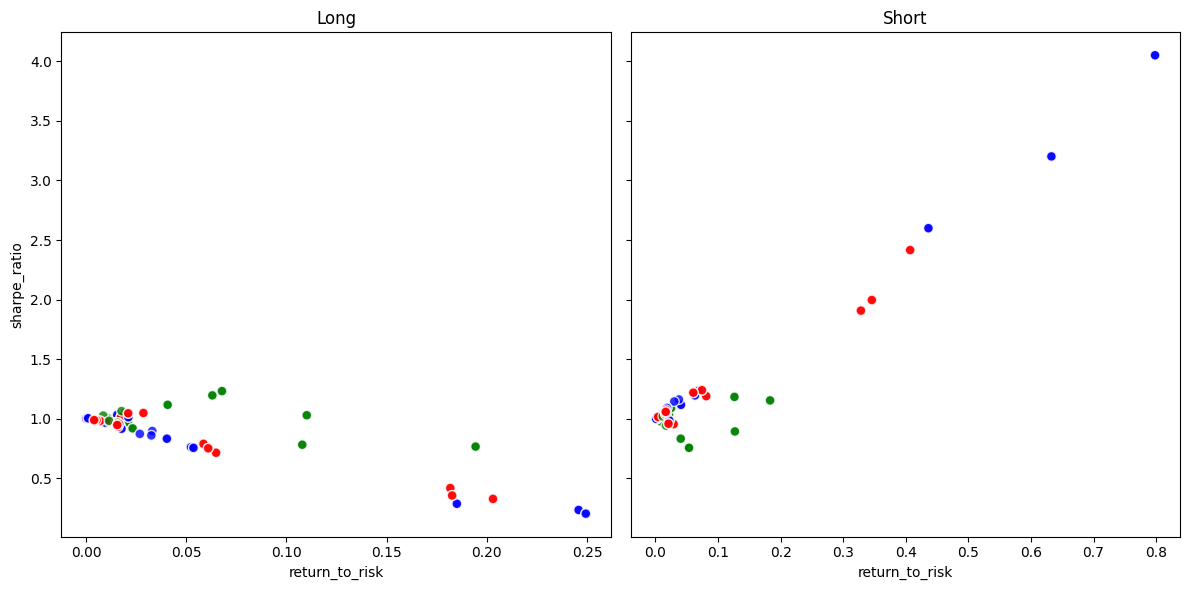

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Titles for each subplot
titles = ["Long", "Short"]

# Iterate over directions and corresponding axes
for i, position_type in enumerate(["long", "short"]):
    d_analysis = a[a["position_type"] == position_type]
    axes[i].scatter(
        d_analysis["portfolio_std"],
        d_analysis["pnl"],
        c=d_analysis["color"],
        s=50,
        alpha=0.8,
        edgecolors="w",
    )
    axes[i].set_title(titles[i])
    axes[i].set_xlabel("return_to_risk")
    axes[i].set_ylabel("sharpe_ratio" if i == 0 else "")  # Only label y-axis on the first plot

# Adjust layout for better spacing
plt.tight_layout()

# Show the combined plot
plt.show()

In [18]:
a.groupby("pnl").first().reset_index().drop("date",axis=1).sort_values("pnl",ascending=False).head(20)

,pnl,timeframe,ranking_metric,position_type,grouping_type,selection_type,allocation_type,risk_type,selection_percentage,coefficient_of_variation,portfolio_std,average_gain,average_loss,win_loss_ratio,weekly_return,sharpe_ratio,portfolio,color,return_to_risk
149,4.052196,week,factor,short,OFFICE,top,equal,coefficient_of_variation,0.01,5.075938,0.798315,1.069655,0.926105,0.578318,1.009122,3.014897,<financial_common.portfolio_management.portfol...,blue,5.075938
148,3.202360,month,factor,short,OFFICE,top,equal,coefficient_of_variation,0.01,5.061285,0.632717,1.182686,0.821917,0.587537,1.033882,2.298245,<financial_common.portfolio_management.portfol...,blue,5.061285
147,2.599433,quarter,factor,short,OFFICE,top,equal,coefficient_of_variation,0.01,5.959209,0.436204,1.330487,0.653394,0.631579,1.081032,1.590372,<financial_common.portfolio_management.portfol...,blue,5.959209
146,2.415498,week,factor,short,OFFICE,bottom,equal,coefficient_of_variation,0.01,5.935560,0.406954,1.066986,0.925117,0.572154,1.006288,1.892448,<financial_common.portfolio_management.portfol...,red,5.935560
145,1.995872,month,factor,short,OFFICE,bottom,equal,coefficient_of_variation,0.01,5.772353,0.345764,1.160234,0.816192,0.599407,1.022413,0.716240,<financial_common.portfolio_management.portfol...,red,5.772353
144,1.906643,quarter,factor,short,OFFICE,bottom,equal,coefficient_of_variation,0.01,5.808067,0.328275,1.288186,0.683465,0.618421,1.057437,0.002855,<financial_common.portfolio_management.portfol...,red,5.808067
143,1.238291,month,factor,short,SIC_DESCRIPTION,bottom,equal,coefficient_of_variation,0.01,16.678071,0.074247,1.102250,0.894817,0.540771,1.006991,-6.868071,<financial_common.portfolio_management.portfol...,red,16.678071
142,1.230717,quarter,factor,long,SIC_DESCRIPTION,mixed,equal,coefficient_of_variation,0.01,18.146736,0.067820,1.177776,0.826876,0.544547,1.017958,-9.952613,<financial_common.portfolio_management.portfol...,green,18.146736
141,1.217342,week,factor,short,SIC_DESCRIPTION,bottom,equal,coefficient_of_variation,0.01,20.165137,0.060369,1.042204,0.956927,0.518402,1.001135,-7.090064,<financial_common.portfolio_management.portfol...,red,20.165137
140,1.194607,month,factor,long,SIC_DESCRIPTION,mixed,equal,coefficient_of_variation,0.01,18.958960,0.063010,1.097616,0.899486,0.536621,1.005807,-8.786131,<financial_common.portfolio_management.portfol...,green,18.958960


In [24]:
top = a.sort_values("pnl",ascending=False).head(1).to_dict("records")[0]
top

{'timeframe': 'week',
 'ranking_metric': 'factor',
 'position_type': 'short',
 'grouping_type': 'OFFICE',
 'selection_type': 'top',
 'allocation_type': 'equal',
 'risk_type': 'coefficient_of_variation',
 'selection_percentage': 0.01,
 'date': Timestamp('2025-03-20 00:00:00+0000', tz='UTC'),
 'pnl': 4.052196443708743,
 'coefficient_of_variation': 5.075938080443135,
 'portfolio_std': 0.798314790190463,
 'average_gain': 1.0696546784441592,
 'average_loss': 0.9261047404222081,
 'win_loss_ratio': 0.5783176214648296,
 'weekly_return': 1.0091221991404866,
 'sharpe_ratio': 3.0148969617147516,
 'portfolio': <financial_common.portfolio_management.portfolio.Portfolio at 0x2358104f3d0>,
 'color': 'blue',
 'return_to_risk': 5.075938080443135}

In [25]:
pm = top["portfolio"]
trades = pm.trades(simulation.copy()).merge(index[["ticker","office","sic_description"]],on="ticker",how="left")
trades = p.additional_date_columns(trades)
portfolio = pm.portfolio(trades.copy(),benchmark.copy())
portfolio = p.additional_date_columns(portfolio)

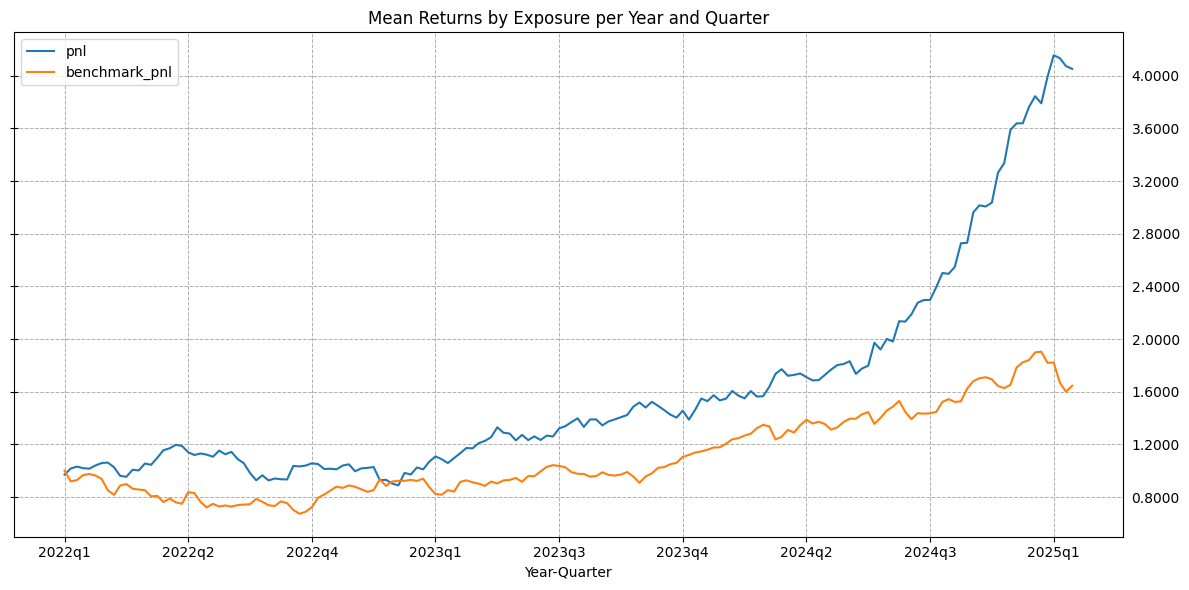

In [26]:
portfolio['Year-Quarter'] = portfolio["year"].astype(str) + "q" + portfolio["quarter"].astype(str)
ax = portfolio[["Year-Quarter","pnl","benchmark_pnl"]].set_index("Year-Quarter").plot(
    kind="line",
    figsize=(12, 6),
    title="Mean Returns by Exposure per Year and Quarter"
)

# Set y-axis to have more precise ticks
ax.tick_params(axis='y', direction='in', length=6)  # Adjust y-tick direction and length
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.4f}'))  # Format y-ticks with 4 decimal places

# Move y-ticks to the right side
ax.yaxis.set_tick_params(which='both', direction='inout', length=6, labelleft=False, labelright=True)

# Optionally adjust the number of ticks for better precision
ax.yaxis.set_major_locator(plt.MaxNLocator(integer=False, prune='both'))

# Add grid lines
ax.grid(True, which='both', axis='both', linestyle='--', linewidth=0.7)

# Display the plot
plt.tight_layout()
plt.show()

In [27]:
portfolio.tail()

,date,return,pnl,benchmark,benchmark_pnl,year,month,quarter,week,Year-Quarter
159,2025-02-21 00:00:00+00:00,1.052896,3.990817,264.24,1.819044,2025,2,1,8,2025q1
160,2025-02-28 00:00:00+00:00,1.041221,4.155324,264.65,1.821867,2025,2,1,9,2025q1
161,2025-03-07 00:00:00+00:00,0.994718,4.133377,242.28,1.667870,2025,3,1,10,2025q1
162,2025-03-14 00:00:00+00:00,0.985367,4.072892,232.44,1.600131,2025,3,1,11,2025q1
163,2025-03-20 00:00:00+00:00,0.994919,4.052196,239.01,1.645360,2025,3,1,12,2025q1


In [28]:
trades[["office","return"]].groupby("office").mean().sort_values("return",ascending=False).tail(20)

KeyError: "['office'] not in index"